In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from stock_env import StockEnv

In [3]:
import pandas as pd
import numpy as np

data = pd.read_csv("AAPL.csv")

In [4]:
data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,1998-01-02,13.63,16.25,13.50,16.25,6411700.0
1,1,1998-01-05,16.50,16.56,15.19,15.88,5820300.0
2,2,1998-01-06,15.94,20.00,14.75,18.94,16182800.0
3,3,1998-01-07,18.81,19.00,17.31,17.50,9300200.0
4,4,1998-01-08,17.44,18.62,16.94,18.19,6910900.0


### Dummy env check:
Let's simply run more env steps that we have data in the dataset, hence the environemnt will go through entire dataframe at least once.

In [5]:
env = StockEnv(data)

/Users/mikhail.zanka/repos/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
observation = env.reset()
n_steps = 0
for _ in range(10000):
    action = (1, 5) # your agent here (this takes random actions)
    observation, reward, done, info = env.step(action)

    if done:
        observation = env.reset()
    n_steps += 1

Last to values of the observation indicate that our agent putted all cash into the stocks, which is expected behaviour.

In [7]:
observation

array([224.18, 224.98, 222.51, 224.45, 15961000.0, 225.38, 225.5, 220.25,
       223.84, 17625100.0, 227.37, 227.73, 225.75, 226.6, 14868700.0,
       223.91, 225.5, 223.32, 225.5, 14489300.0, 223.8295, 225.48, 223.2,
       224.84, 21293500.0, 223.36422182956173, 0.0, 112.38388624328505],
      dtype=object)

In [8]:
env.capital

25153.59171122691

## Train with stable-baselines-v3 (Pytorch version)

In [9]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import DummyVecEnv

/Users/mikhail.zanka/opt/anaconda3/lib/python3.7/site-packages/setuptools/distutils_patch.py:26: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  "Distutils was imported before Setuptools. This usage is discouraged "


In [10]:
env = DummyVecEnv([lambda: StockEnv(data)])

/Users/mikhail.zanka/repos/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [11]:
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=20000)
model.save("ppo_stock")

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 598  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 545         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.003946802 |
|    clip_fraction        | 0.0208      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.85       |
|    explained_variance   | 2.88e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 3.67e+03    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00394    |
|    std                  | 1.01        |
|    value_loss           | 9.23e+03    |
-----------------

## Policy check
Let's do a quick check returns (total change of capital), to understand how our policy performs:

In [41]:
model = PPO.load("ppo_stock")

episode_rewards = []
for _ in range(10):
    obs = env.reset()
    all_rewards = []
    while True:
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        all_rewards.append(rewards)
        if dones[0]:
            break
            
    episode_rewards.append(np.sum(np.concatenate(all_rewards)))

High variance of the returns indicates that our policy doesn't perform well.

In [45]:
episode_rewards = np.array(episode_rewards)
np.mean(episode_rewards), np.std(episode_rewards)

(-3955.1226, 5273.6826)

## Visualizing training progress:

Let's visualize 2 of the basic RL metrics: losses of the policy and value function that we learning.  
Reward wasn't used for visualization because it's hard to extract from the stable-baselines without tensorboard.

In [63]:
from stable_baselines3.common.logger import configure
import matplotlib.pyplot as plt

In [48]:
tmp_path = "/tmp/sb3_log/"
# set up logger
new_logger = configure(tmp_path, ["csv"])

model = PPO("MlpPolicy", env, verbose=1)
# Set new logger
model.set_logger(new_logger)
model.learn(20000)

Using cpu device


In [49]:
logs = pd.read_csv("/tmp/sb3_log/progress.csv")

In [61]:
logs.head()

,time/time_elapsed,time/total_timesteps,time/iterations,time/fps,train/policy_gradient_loss,train/n_updates,train/learning_rate,train/explained_variance,train/clip_range,train/std,train/entropy_loss,train/loss,train/approx_kl,train/value_loss,train/clip_fraction
0,3,2048,1,600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,4096,2,554,-0.003963,10.0,0.0003,0.000145,0.2,0.992703,-2.831505,2225.710938,0.006827,1.882349e+04,0.050000
2,11,6144,3,533,-0.001701,20.0,0.0003,0.000119,0.2,0.988618,-2.817751,88802.515625,0.002473,1.105717e+05,0.013232
3,15,8192,4,525,-0.005899,30.0,0.0003,-0.000780,0.2,0.973392,-2.800353,5083.414551,0.006648,7.072342e+03,0.065186
4,19,10240,5,521,-0.003772,40.0,0.0003,0.000012,0.2,0.972896,-2.782533,128967.398438,0.003485,1.756152e+06,0.019873


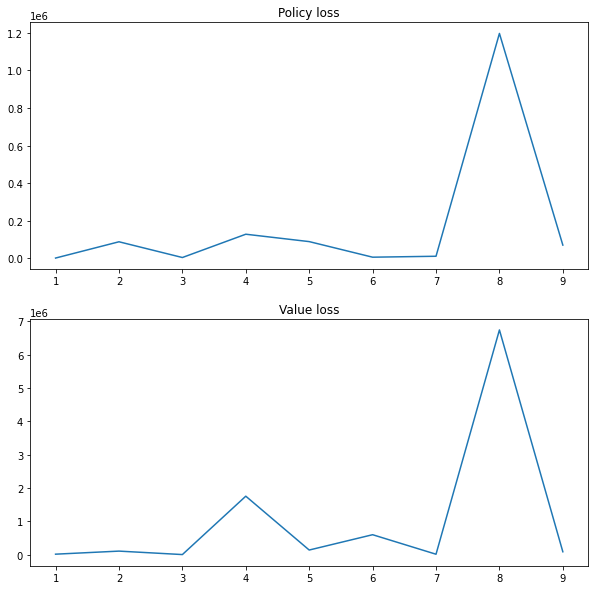

In [75]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.title("Policy loss")
logs["train/loss"].plot()

plt.subplot(212)
plt.title("Value loss")
logs["train/value_loss"].plot()